In [2]:
%load_ext autoreload
%autoreload 1

print('please anything')

import SimpleITK as sitk
import os, sys

print('zapatos')

sys.path.append('./workflow/libs/')
%aimport utils
%aimport config
%aimport segment 
%aimport match 
%aimport missingness 
%aimport register 
%aimport evaluate 
%aimport qc 

print('yabadabodoo')

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sbn
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

pd.set_option('display.max_columns', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
please anything
zapatos
yabadabodoo


# Results Visualization 

Tool for interacting with results on exahead. 


## Overview

The file `aggregated_results.csv` is formed from three different sources: 
- each core-directory's parsed names: This contains the core name and the absolute path; This can be used to track and organize the data. **BUG** - currently R0 is not included in this dataset. 
- the original core segmentation stats: this will include the original file name and segmentation statistics. 
- registration results: This contains registration success metrics 

Because of this, there is substantial missingness between row observations depending on which source it came from. 

## Data Dictionary 

> **status**: whether the core has been registered or not. Note that `R0-c1` will never be titled as `registered` since this is the reference image.  

> **core**: core identifier, this is the core cluster label assigned during segmentation and across-round matching.   

> **round**: The image round identifier, should be in format `R<int>`. Note that R0 is autofluorescence only, except for R0,c1 which is DAPI used for registration reference frame. 

> **color_channel**: fluorescence wavelength measured. c1 is always DAPI, c2-5 may reflect different protein antibodies depending on the round. The specific channel-protein mapping is encoded in the original scan name. 

> **path**: *local path* or core file name. 

> **center_x/y**: core segmentation center x/y coordinate, in reference to the original (potentially downsampled) scan image (full scan-scene).  

> **width/height**: core segmentation width/height (potentitally downsampled); see config.py for details.  

> **volume (nm^3)**:  

> **Elongation**:  

> **Flatness**:  

> **Oriented Bounding Box Minimum/Maximum Size(nm)**:  

> **Intensity Mean**:  

> **Intensity Standard Deviation**:  

> **Intensity Skewness**:  

> **component**:  *why isn't this the same as `core` - aren't they assigned the same way??*   

> **img_name**: original scan-scene image name  

> **protein**: 

> **slide_name**:  

> **date**:  

> **scan_id**:  

> **scene**:  

> **note**:  

> **file_type**:  

> **original**: duplicate of `img_name`  

> **cluster**:  

> **name**: duplicate of `path` 

> **jacaard_coef**:  

> **dice_coef**:  

> **volume_similarity**:  

> **false_neg_err**:  

> **false_pos_err**:  

> **hausdorff_dist**:  

> **registered_path**: absolute path to this image, can be used for access and tracking.   

In [3]:
res = pd.read_csv('/home/exacloud/lustre1/NGSdev/evansna/cyclicIF/output/aggregated_results.csv')

# drop unnecessary columns 
res = res.drop(['Unnamed: 0', 'Unnamed: 0_x', 'Unnamed: 0_y'], axis=1)

# select only registered results -- keep R0 unregistered as this is the aligned reference 
res = res[(res.status == 'registered') | (res.round == 'R0')]

res.head()

status  core round color_channel  \
2   registered    56    R1            c1   
3   registered    56    R2            c3   
6   registered    56    R1            c4   
10  registered    56    R2            c5   
16  registered    56    R1            c5   

                                        path  center_x  center_y  width  \
2   registered_core=56_round=R1_color=c1.tif    1079.0    1124.0  122.0   
3   registered_core=56_round=R2_color=c3.tif       NaN       NaN    NaN   
6   registered_core=56_round=R1_color=c4.tif       NaN       NaN    NaN   
10  registered_core=56_round=R2_color=c5.tif       NaN       NaN    NaN   
16  registered_core=56_round=R1_color=c5.tif       NaN       NaN    NaN   

    height  Volume (nm^3)  Elongation  Flatness  \
2    117.0       0.470113    1.039698  1.039698   
3      NaN            NaN         NaN       NaN   
6      NaN            NaN         NaN       NaN   
10     NaN            NaN         NaN       NaN   
16     NaN            NaN         NaN       NaN   

    Oriented Bounding Box Minimum Size(nm)  \
2                                 0.771342   
3                                      NaN   
6                                      NaN   
10                                     NaN   
16                                     NaN   

    Oriented Bounding Box Maximum Size(nm)  Intensity Mean  \
2                                 0.799247       14.819089   
3                                      NaN             NaN   
6                                      NaN             NaN   
10                                     NaN             NaN   
16                                     NaN             NaN   

    Intensity Standard Deviation  Intensity Skewness  component  \
2                      14.666503             1.53097       55.0   
3                            NaN                 NaN        NaN   
6                            NaN                 NaN        NaN   
10                           NaN                 NaN        NaN   
16                           NaN                 NaN        NaN   

                                             img_name  \
2   R1_H3K27me3.CCNB1.CCND1.Ki67_S3_2020_01_22__13...   
3                                                 NaN   
6                                                 NaN   
10                                                NaN   
16                                                NaN   

                      protein slide_name        date  scan_id    scene note  \
2   H3K27me3.CCNB1.CCND1.Ki67         S3  2020-01-22  13485.0  Scene-1  ORG   
3                         NaN        NaN         NaN      NaN      NaN  NaN   
6                         NaN        NaN         NaN      NaN      NaN  NaN   
10                        NaN        NaN         NaN      NaN      NaN  NaN   
16                        NaN        NaN         NaN      NaN      NaN  NaN   

   file_type                                           original  cluster  \
2        tif  R1_H3K27me3.CCNB1.CCND1.Ki67_S3_2020_01_22__13...     56.0   
3        NaN                                                NaN      NaN   
6        NaN                                                NaN      NaN   
10       NaN                                                NaN      NaN   
16       NaN                                                NaN      NaN   

                                        name  jacaard_coef  dice_coef  \
2   registered_core=56_round=R1_color=c1.tif      0.760846   0.864182   
3                                        NaN           NaN        NaN   
6                                        NaN           NaN        NaN   
10                                       NaN           NaN        NaN   
16                                       NaN           NaN        NaN   

    volume_similarity  false_neg_err  false_pos_err  hausdorff_dist  \
2             -0.0374       0.151681       0.119349         0.09009   
3                 NaN            NaN            NaN             NaN   
6    

In [4]:
res[res.slide_name.isna()]

status  core round color_channel  \
3     registered    56    R2            c3   
6     registered    56    R1            c4   
10    registered    56    R2            c5   
16    registered    56    R1            c5   
18    registered    56    R2            c4   
...          ...   ...   ...           ...   
1971  registered    49    R2            c4   
1972  registered    49    R1            c2   
1979  registered    49    R2            c5   
1981  registered    49    R2            c3   
1984  registered    49    R1            c3   

                                          path  center_x  center_y  width  \
3     registered_core=56_round=R2_color=c3.tif       NaN       NaN    NaN   
6     registered_core=56_round=R1_color=c4.tif       NaN       NaN    NaN   
10    registered_core=56_round=R2_color=c5.tif       NaN       NaN    NaN   
16    registered_core=56_round=R1_color=c5.tif       NaN       NaN    NaN   
18    registered_core=56_round=R2_color=c4.tif       NaN       NaN    NaN   
...                                        ...       ...       ...    ...   
1971  registered_core=49_round=R2_color=c4.tif       NaN       NaN    NaN   
1972  registered_core=49_round=R1_color=c2.tif       NaN       NaN    NaN   
1979  registered_core=49_round=R2_color=c5.tif       NaN       NaN    NaN   
1981  registered_core=49_round=R2_color=c3.tif       NaN       NaN    NaN   
1984  registered_core=49_round=R1_color=c3.tif       NaN       NaN    NaN   

      height  Volume (nm^3)  Elongation  Flatness  \
3        NaN            NaN         NaN       NaN   
6        NaN            NaN         NaN       NaN   
10       NaN            NaN         NaN       NaN   
16       NaN            NaN         NaN       NaN   
18       NaN            NaN         NaN       NaN   
...      ...            ...         ...       ...   
1971     NaN            NaN         NaN       NaN   
1972     NaN            NaN         NaN       NaN   
1979     NaN            NaN         NaN       NaN   
1981     NaN            NaN         NaN       NaN   
1984     NaN            NaN         NaN       NaN   

      Oriented Bounding Box Minimum Size(nm)  \
3                                        NaN   
6                                        NaN   
10                                       NaN   
16                                       NaN   
18                                       NaN   
...                                      ...   
1971                                     NaN   
1972                                     NaN   
1979                                     NaN   
1981                                     NaN   
1984                                     NaN   

      Oriented Bounding Box Maximum Size(nm)  Intensity Mean  \
3                                        NaN             NaN   
6                                        NaN             NaN   
10                                       NaN             NaN   
16                                       NaN             NaN   
18                                       NaN             NaN   
...                                      ...             ...   
1971                                     NaN             NaN   
1972                                     NaN             NaN   
1979                                     NaN             NaN   
1981                                     NaN             NaN   
1984                                     NaN             NaN   

      Intensity Standard Deviation  Intensity Skewness  component img_name  \
3                              NaN                 NaN        NaN      NaN   
6                              NaN                 NaN        NaN      NaN   
10                             NaN                 NaN        NaN      NaN   
16                             NaN                 NaN        NaN      NaN   
18                             NaN                 NaN        NaN      NaN   
...                            ...                 ...        ...      ...   
197

## Available experiments 

why isn't `R0` available here? 


In [5]:
res[['slide_name', 'scene', 'round']].drop_duplicates()

slide_name    scene round
2          S3  Scene-1    R1
3         NaN      NaN    R2
6         NaN      NaN    R1
22         S3  Scene-1    R2

## choose experiment 

In [6]:
# results config params 

SCENE = 'Scene-1'
SLIDE = 'S3'

res = res[(res.slide_name == SLIDE) & (res.scene == SCENE)]

## Registration results 

In [7]:
# select only the DAPI results
regRes = res[res.color_channel == 'c1']
regRes.head()

status  core round color_channel  \
2   registered    56    R1            c1   
22  registered    56    R2            c1   
37  registered    76    R1            c1   
48  registered    76    R2            c1   
50  registered    80    R2            c1   

                                        path  center_x  center_y  width  \
2   registered_core=56_round=R1_color=c1.tif    1079.0    1124.0  122.0   
22  registered_core=56_round=R2_color=c1.tif    1063.0    1116.0  125.0   
37  registered_core=76_round=R1_color=c1.tif    1691.0     594.0  101.0   
48  registered_core=76_round=R2_color=c1.tif    1683.0     584.0  105.0   
50  registered_core=80_round=R2_color=c1.tif     937.0     583.0   79.0   

    height  Volume (nm^3)  Elongation  Flatness  \
2    117.0       0.470113    1.039698  1.039698   
22   128.0       0.520010    1.045865  1.045865   
37    96.0       0.295030    1.155490  1.155490   
48   115.0       0.372262    1.023528  1.023528   
50    99.0       0.251048    1.272651  1.272651   

    Oriented Bounding Box Minimum Size(nm)  \
2                                 0.771342   
22                                0.802542   
37                                0.583131   
48                                0.684474   
50                                0.512499   

    Oriented Bounding Box Maximum Size(nm)  Intensity Mean  \
2                                 0.799247       14.819089   
22                                0.858605        6.737325   
37                                0.648672       12.609767   
48                                0.756406        5.611962   
50                                0.646299        6.234096   

    Intensity Standard Deviation  Intensity Skewness  component  \
2                      14.666503            1.530970       55.0   
22                      8.108660            1.747507       57.0   
37                     22.753872            3.096577       76.0   
48                     11.940974            3.673962       76.0   
50                     11.605617            3.054585       79.0   

                                             img_name  \
2   R1_H3K27me3.CCNB1.CCND1.Ki67_S3_2020_01_22__13...   
22  R2_PCNA.AR.ER.GATA3_S3_2020_01_23__13492-Scene...   
37  R1_H3K27me3.CCNB1.CCND1.Ki67_S3_2020_01_22__13...   
48  R2_PCNA.AR.ER.GATA3_S3_2020_01_23__13492-Scene...   
50  R2_PCNA.AR.ER.GATA3_S3_2020_01_23__13492-Scene...   

                      protein slide_name        date  scan_id    scene note  \
2   H3K27me3.CCNB1.CCND1.Ki67         S3  2020-01-22  13485.0  Scene-1  ORG   
22           PCNA.AR.ER.GATA3         S3  2020-01-23  13492.0  Scene-1  ORG   
37  H3K27me3.CCNB1.CCND1.Ki67         S3  2020-01-22  13485.0  Scene-1  ORG   
48           PCNA.AR.ER.GATA3         S3  2020-01-23  13492.0  Scene-1  ORG   
50           PCNA.AR.ER.GATA3         S3  2020-01-23  13492.0  Scene-1  ORG   

   file_type                                           original  cluster  \
2        tif  R1_H3K27me3.CCNB1.CCND1.Ki67_S3_2020_01_22__13...     56.0   
22       tif  R2_PCNA.AR.ER.GATA3_S3_2020_01_23__13492-Scene...     56.0   
37       tif  R1_H3K27me3.CCNB1.CCND1.Ki67_S3_2020_01_22__13...     76.0   
48       tif  R2_PCNA.AR.ER.GATA3_S3_2020_01_23__13492-Scene...     76.0   
50       tif  R2_PCNA.AR.ER.GATA3_S3_2020_01_23__13492-Scene...     80.0   

                                        name  jacaard_coef  dice_coef  \
2   registered_core=56_round=R1_color=c1.tif      0.760846   0.864182   
22  registered_core=56_round=R2_color=c1.tif      0.602654   0.752070   
37  registered_core=76_round=R1_color=c1.tif      0.712534   0.832140   
48  registered_core=76_round=R2_color=c1.tif      0.484181   0.652455   
50  registered_core=80_round=R2_color=c1.tif      0.507941   0.673688   

    volume_similarity  false_neg_err  false_pos_err  hausdorff_dist  \
2           -0.037400       0.151681       0.119349        0.090090   
22           0.022333       0.239437       0.256236        0.090247   
37   

# Registration Results 

Why is there such clear separation between rounds? 
- something to do with lost material? I guess we would expect later rounds to register more poorly... 

Note: R1 has better metrics than R2. 

In [8]:
vizRes = regRes[['round',*'jacaard_coef,dice_coef,volume_similarity,false_neg_err,false_pos_err,hausdorff_dist'.split(',')]]

In [10]:
vizRes.describe()

jacaard_coef   dice_coef  volume_similarity  false_neg_err  \
count    159.000000  159.000000         159.000000     159.000000   
mean       0.590351    0.725713           0.029829       0.262611   
std        0.170474    0.160126           0.159978       0.151202   
min        0.008541    0.016937          -0.296685       0.018245   
25%        0.503396    0.669666          -0.040598       0.174393   
50%        0.612614    0.759777           0.016723       0.230670   
75%        0.718445    0.836157           0.065646       0.305440   
max        0.969828    0.984683           1.070265       0.982713   

       false_pos_err  hausdorff_dist  
count     159.000000      159.000000  
mean        0.277640        0.057929  
std         0.177268        0.068576  
min         0.010536        0.005993  
25%         0.147187        0.014570  
50%         0.242996        0.025425  
75%         0.356023        0.073779  
max         0.983399        0.311283

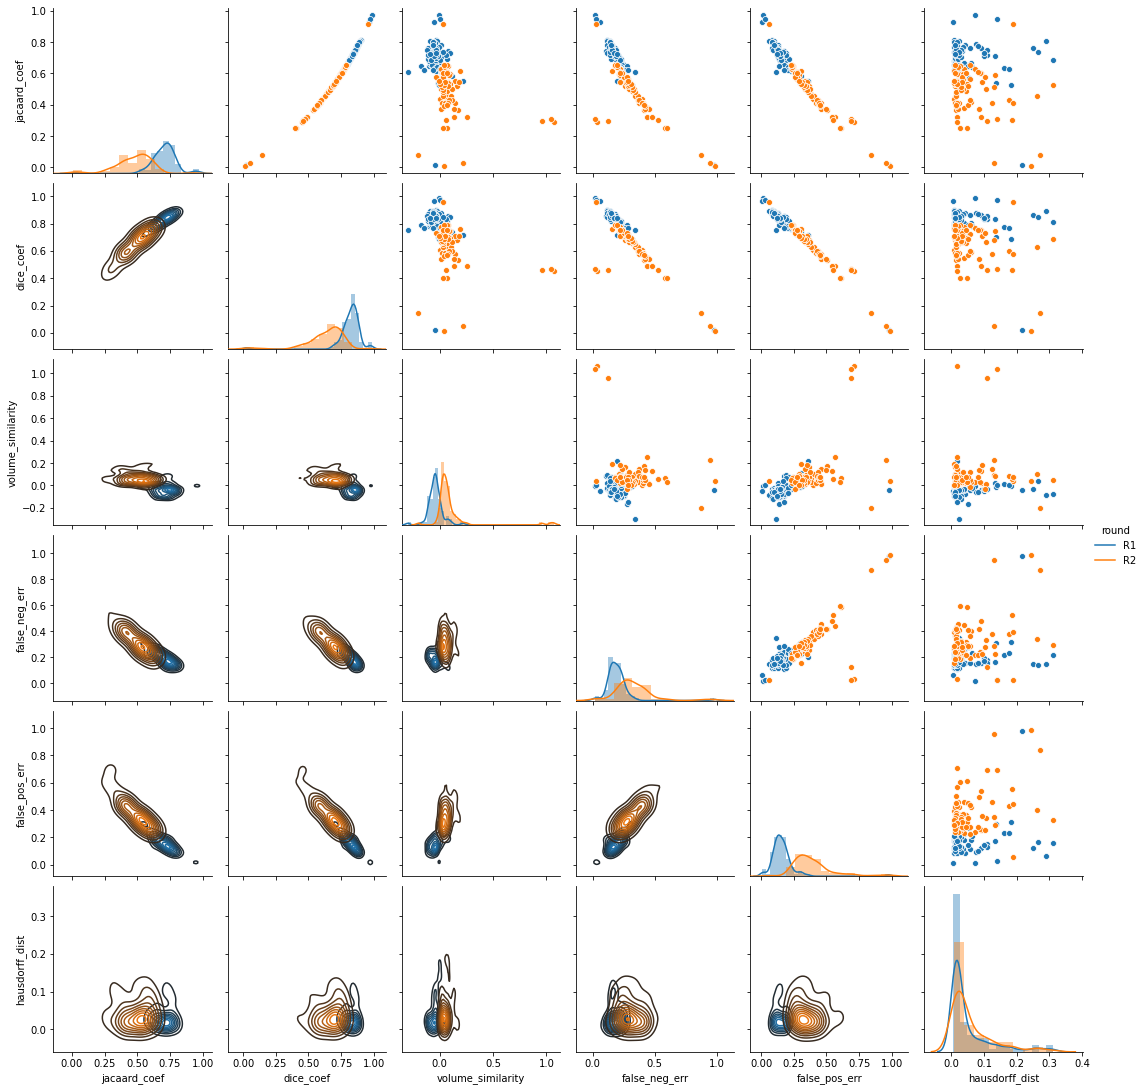

In [11]:
g = sbn.PairGrid(vizRes, hue='round')
g.map_upper(sbn.scatterplot)
g.map_diag(sbn.distplot)
g.map_lower(sbn.kdeplot)
g.add_legend()

## Outlier detection


Outlier detection does work, however, it also selects the *Really GOOD* registrations as outliers. It might be better to hardcode thresholds for **poor** registration... 

https://scikit-learn.org/stable/modules/outlier_detection.html

https://scikit-learn.org/stable/auto_examples/ensemble/plot_isolation_forest.html#sphx-glr-auto-examples-ensemble-plot-isolation-forest-py

In [12]:
regRes['jacaard_coef,dice_coef,volume_similarity,false_neg_err,false_pos_err,hausdorff_dist'.split(',')].corr(method='spearman')

jacaard_coef  dice_coef  volume_similarity  false_neg_err  \
jacaard_coef           1.000000   1.000000          -0.616262      -0.862443   
dice_coef              1.000000   1.000000          -0.616262      -0.862443   
volume_similarity     -0.616262  -0.616262           1.000000       0.302493   
false_neg_err         -0.862443  -0.862443           0.302493       1.000000   
false_pos_err         -0.975782  -0.975782           0.730138       0.783992   
hausdorff_dist        -0.178492  -0.178492           0.128735       0.130996   

                   false_pos_err  hausdorff_dist  
jacaard_coef           -0.975782       -0.178492  
dice_coef              -0.975782       -0.178492  
volume_similarity       0.730138        0.128735  
false_neg_err           0.783992        0.130996  
false_pos_err           1.000000        0.167864  
hausdorff_dist          0.167864        1.000000

In [13]:
## Exclude jacaard and dice since they are highly correlated [by rank] with the other features
## what proportion of outliers do we expect?????

X = regRes['volume_similarity,false_neg_err,false_pos_err,hausdorff_dist'.split(',')].values

clf = IsolationForest(max_samples='auto', bootstrap=True, contamination=0.15, max_features=3)
clf.fit(X)

outliers = clf.predict(X)

_, cnts = np.unique(outliers, return_counts=True)

print(f'number of outliers: {cnts[0]}/{cnts[1]} [{100*cnts[0]/np.sum(cnts):.1f}%]')

number of outliers: 24/135 [15.1%]


In [14]:
pca = PCA(n_components=2, svd_solver='full')
pca.fit(X)
PC = pca.transform(X)

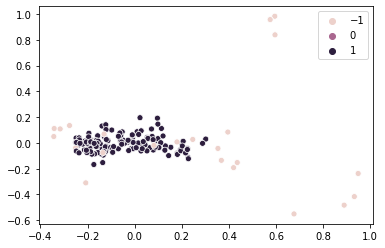

In [15]:
plt.figure()
sbn.scatterplot(PC[:,0], PC[:,1], hue=outliers)
plt.show()

In [28]:
#outliersBool = outliers == -1
outliersBool = PC[:,0] > 0.2
outRes = regRes[outliersBool]

print('number of outliers:', outRes.shape[0])

number of outliers: 23


## Manual thresholding 

We'll try just using the 10th/90th percentiles

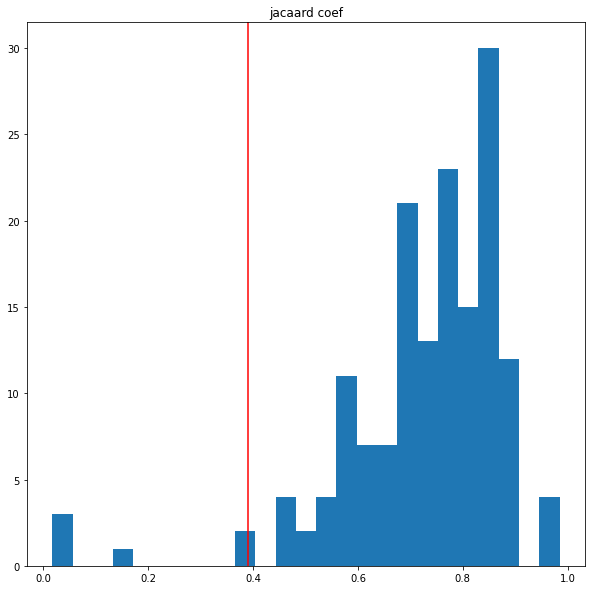

In [17]:
# higher is better 
vs_thresh = np.quantile(vizRes.jacaard_coef, 0.1)
plt.figure(figsize=(10,10))
plt.hist(vizRes.dice_coef, bins=25)
plt.axvline(vs_thresh, c='r')
plt.title('jacaard coef')
plt.show()

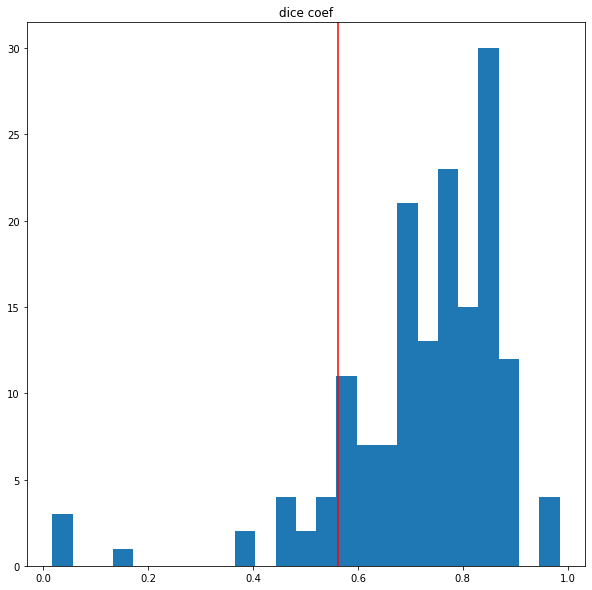

In [18]:
# higher is better 
vs_thresh = np.quantile(vizRes.dice_coef, 0.1)
plt.figure(figsize=(10,10))
plt.hist(vizRes.dice_coef, bins=25)
plt.axvline(vs_thresh, c='r')
plt.title('dice coef')
plt.show()

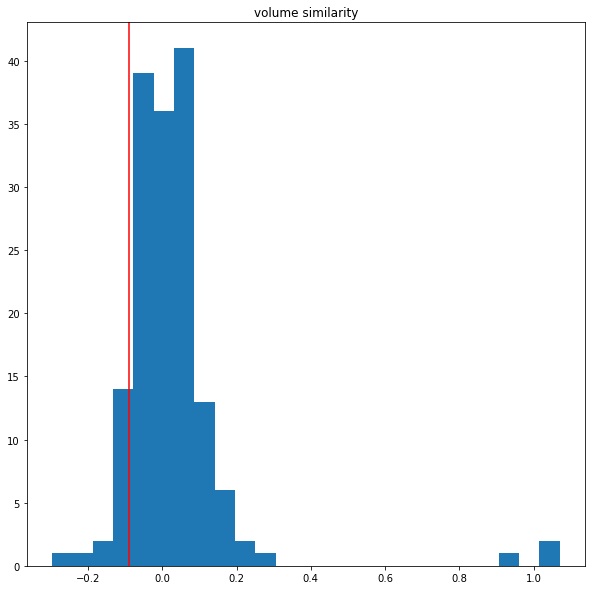

In [19]:
# higher is better 
vs_thresh = np.quantile(vizRes.volume_similarity, 0.1)
plt.figure(figsize=(10,10))
plt.hist(vizRes.volume_similarity, bins=25)
plt.axvline(vs_thresh, c='r')
plt.title('volume similarity')
plt.show()

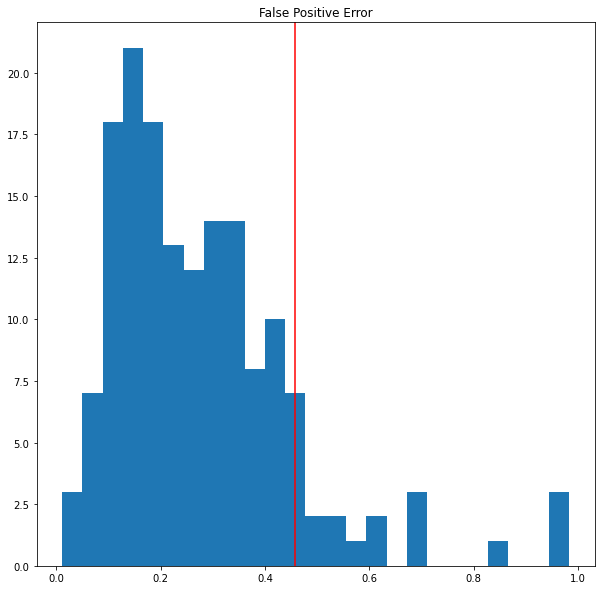

In [20]:
# lower is better 
FP_thresh = np.quantile(vizRes.false_pos_err, 0.9)
plt.figure(figsize=(10,10))
plt.hist(vizRes.false_pos_err, bins=25)
plt.axvline(FP_thresh, c='r')
plt.title('False Positive Error')
plt.show()

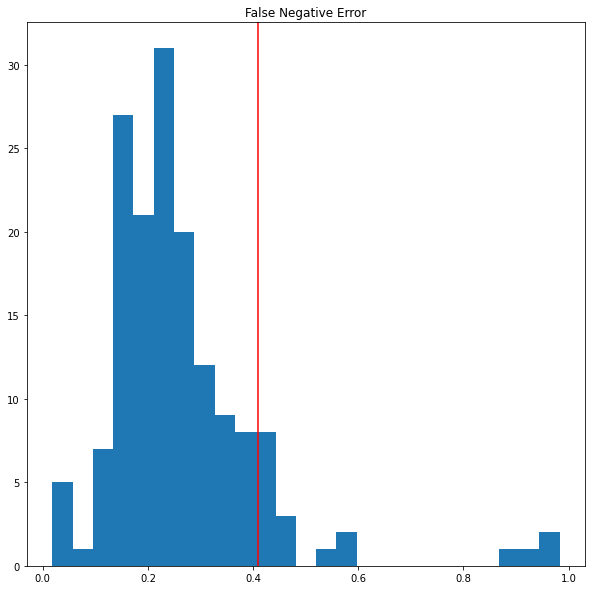

In [21]:
# lower is better 
FN_thresh = np.quantile(vizRes.false_neg_err, 0.9)
plt.figure(figsize=(10,10))
plt.hist(vizRes.false_neg_err, bins=25)
plt.axvline(FN_thresh, c='r')
plt.title('False Negative Error')
plt.show()

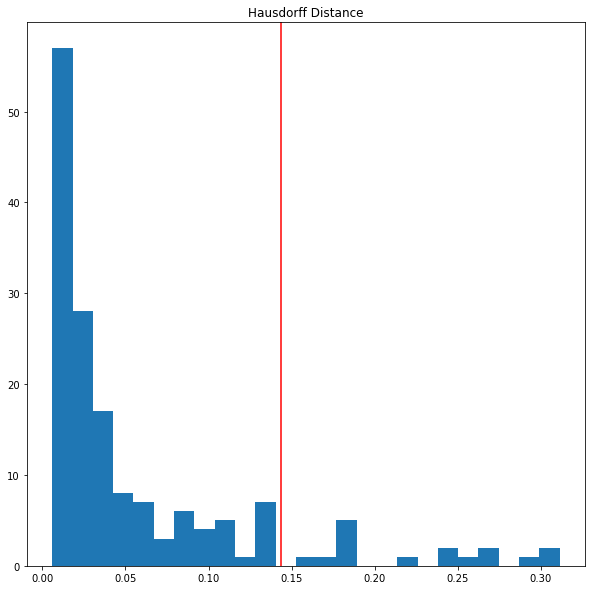

In [22]:
# lower is better 
hd_thresh = np.quantile(vizRes.hausdorff_dist, 0.9)
plt.figure(figsize=(10,10))
plt.hist(vizRes.hausdorff_dist, bins=25)
plt.axvline(hd_thresh, c='r')
plt.title('Hausdorff Distance')
plt.show()

In [32]:
FPR_threshold = 0.5
FNR_threshold = 0.5
hausdorff_distance_threshold = 0.2

outRes = regRes[lambda x: (x.false_pos_err > config.FPR_threshold) | (x.false_neg_err > config.FNR_threshold) | (x.hausdorff_dist > config.hausdorff_distance_threshold)]

print('number of outliers:', outRes.shape[0])

print(f'number of outliers: {outRes.shape[0]}/{regRes.shape[0]} [{100*outRes.shape[0]/regRes.shape[0]:.1f}%]')

number of outliers: 19
number of outliers: 19/159 [11.9%]


## inspect possible outliers

##################################################
registered_core=73_round=R2_color=c1.tif
##################################################
jacaard: 0.3225422074193178
dice: 0.4877609283240884
volume similarity: 0.2562009487315871
FPR: 0.5676263423270852
FNR: 0.4405766788675581
hausdorff dist: 0.017160402028433188


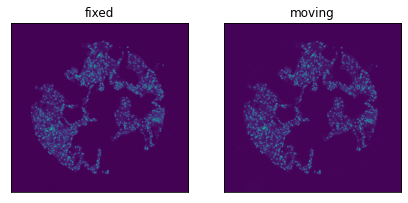

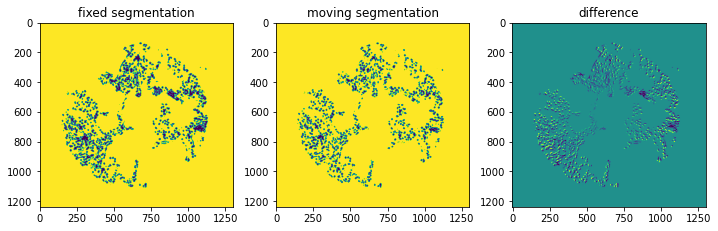

##################################################
registered_core=33_round=R2_color=c1.tif
##################################################
jacaard: 0.07735049299628452
dice: 0.14359392509518493
volume similarity: -0.19986944791617933
FPR: 0.8404627654044742
FNR: 0.8694523211536903
hausdorff dist: 0.27181983305186985


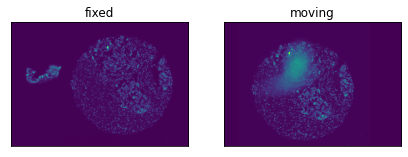

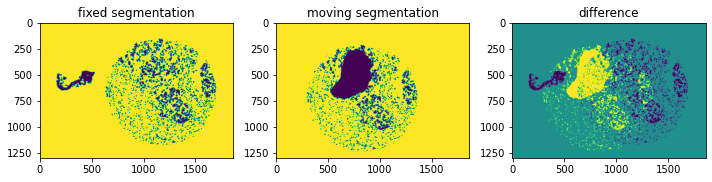

##################################################
registered_core=1_round=R2_color=c1.tif
##################################################
jacaard: 0.3233540233855156
dice: 0.4886886164569692
volume similarity: 0.13095872323765806
FPR: 0.5413438926545857
FNR: 0.4770702792572854
hausdorff dist: 0.09155727273817067


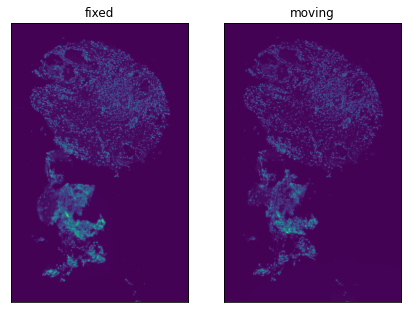

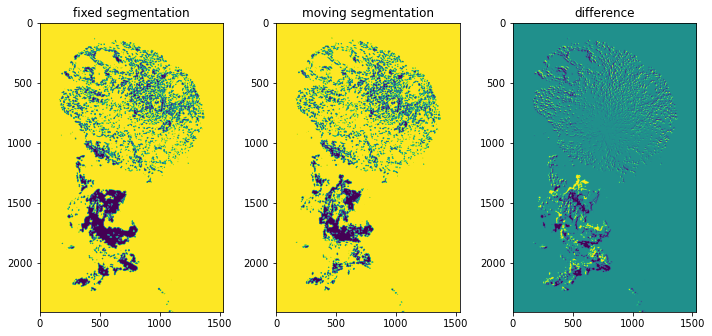

##################################################
registered_core=26_round=R1_color=c1.tif
##################################################
jacaard: 0.8088857478225974
dice: 0.8943469744247522
volume similarity: -0.08926387777307485
FPR: 0.06387180938160296
FNR: 0.14386403370164305
hausdorff dist: 0.2895601608052865


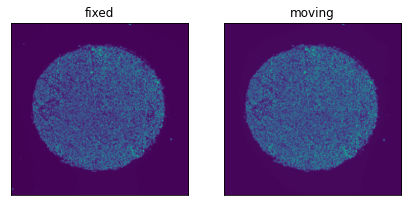

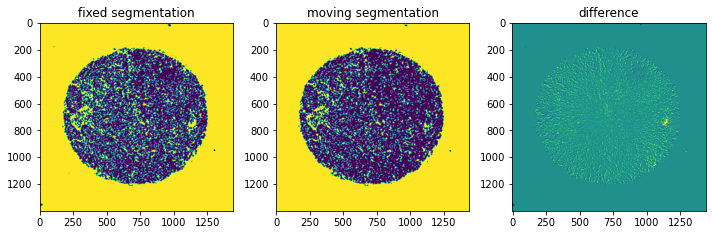

##################################################
registered_core=26_round=R2_color=c1.tif
##################################################
jacaard: 0.4574545534098464
dice: 0.6277445184682983
volume similarity: 0.10437780351795377
FPR: 0.4033918078599021
FNR: 0.3376902637737775
hausdorff dist: 0.2615959653579342


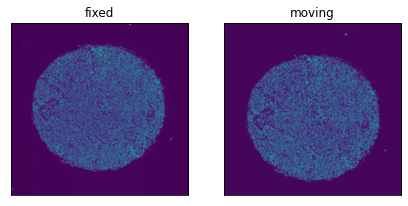

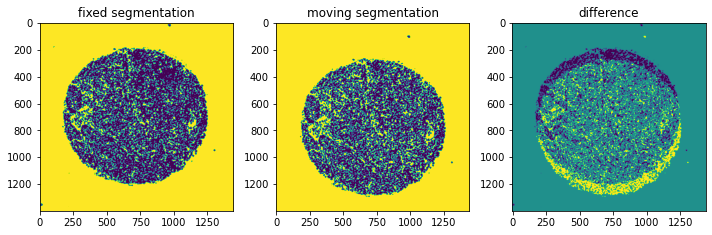

##################################################
registered_core=27_round=R2_color=c1.tif
##################################################
jacaard: 0.25189030805384305
dice: 0.40241594081102094
volume similarity: 0.06955647536541497
FPR: 0.6111090027248783
FNR: 0.5830844718576322
hausdorff dist: 0.04914679088866152


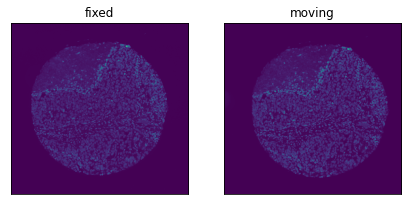

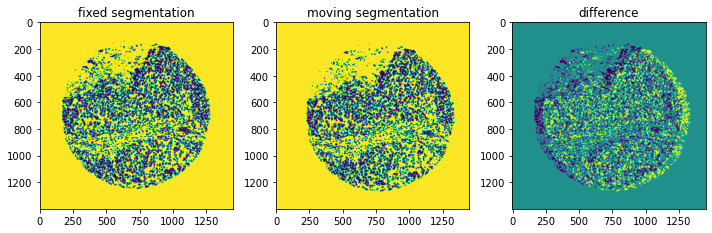

##################################################
registered_core=67_round=R2_color=c1.tif
##################################################
jacaard: 0.36675691012697137
dice: 0.5366819913760666
volume similarity: 0.17063624214482498
FPR: 0.5055072047946952
FNR: 0.4132583100855832
hausdorff dist: 0.015734751088550342


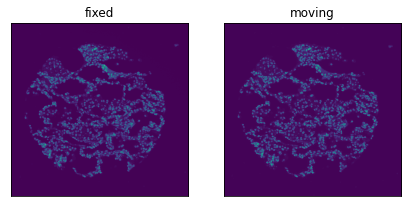

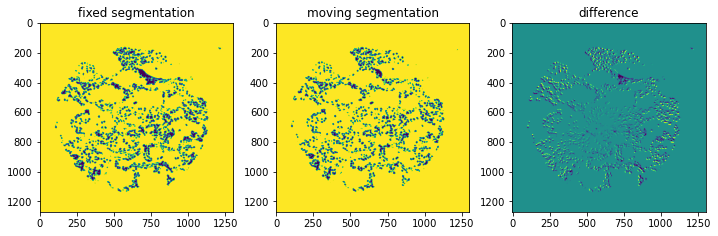

##################################################
registered_core=52_round=R2_color=c1.tif
##################################################
jacaard: 0.2899696778897137
dice: 0.4495759595901211
volume similarity: 1.0702645074484038
FPR: 0.7071418710020206
FNR: 0.03289491862617778
hausdorff dist: 0.017160402028433268


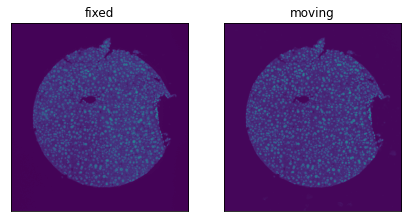

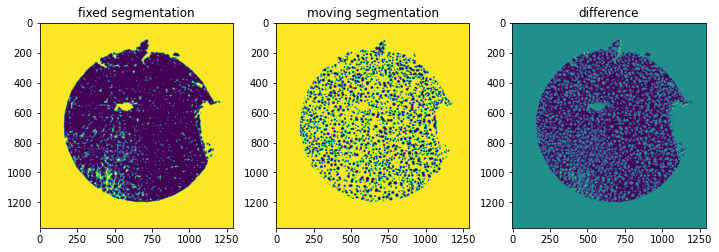

##################################################
registered_core=28_round=R2_color=c1.tif
##################################################
jacaard: 0.2988873911554749
dice: 0.4602206368168501
volume similarity: 0.05809346476329037
FPR: 0.5527699351887482
FNR: 0.5260115474499382
hausdorff dist: 0.18504821470463584


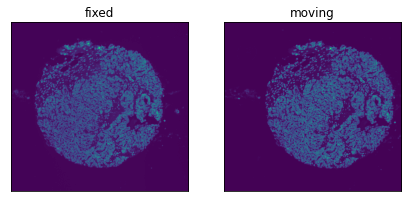

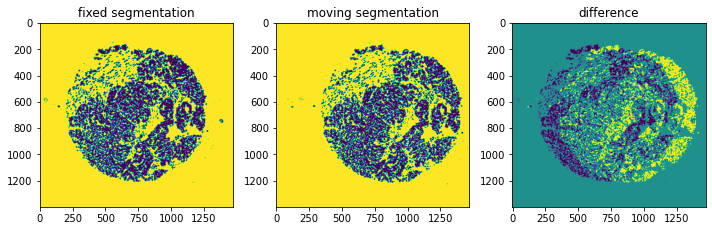

##################################################
registered_core=28_round=R1_color=c1.tif
##################################################
jacaard: 0.7586662295696155
dice: 0.8627745467714789
volume similarity: -0.02912592403229586
FPR: 0.12447521910007912
FNR: 0.14960965551416705
hausdorff dist: 0.24958260412985345


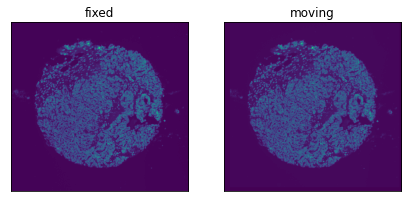

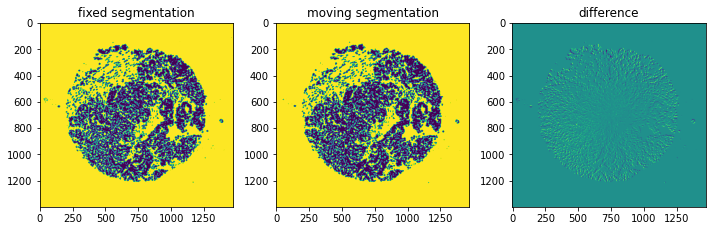

##################################################
registered_core=7_round=R1_color=c1.tif
##################################################
jacaard: 0.011837729648061185
dice: 0.02339847448103877
volume similarity: -0.045242181907745364
FPR: 0.976059976059976
FNR: 0.9771191160753264
hausdorff dist: 0.21561474961006705


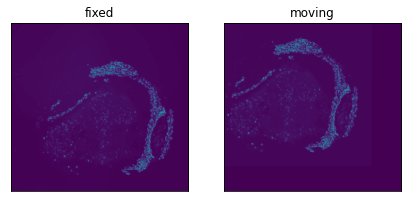

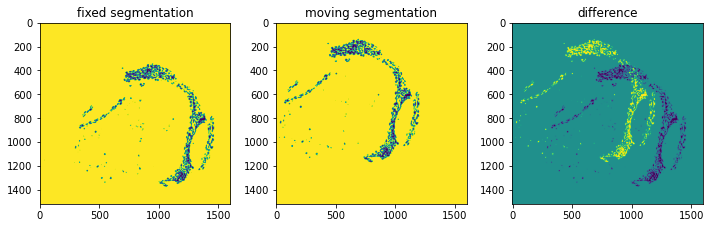

##################################################
registered_core=7_round=R2_color=c1.tif
##################################################
jacaard: 0.008540844522595964
dice: 0.016937032484071315
volume similarity: 0.04054282064261094
FPR: 0.9833994833994834
FNR: 0.9827125260378226
hausdorff dist: 0.2450625019010176


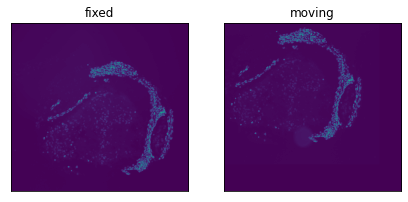

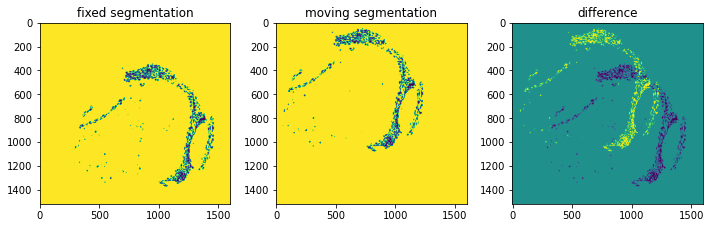

##################################################
registered_core=78_round=R2_color=c1.tif
##################################################
jacaard: 0.02603541153087096
dice: 0.05074953795605448
volume similarity: 0.22260250530494904
FPR: 0.9543332306744688
FNR: 0.942894554417315
hausdorff dist: 0.13175704770598715


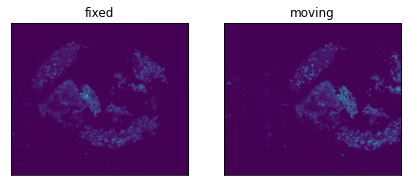

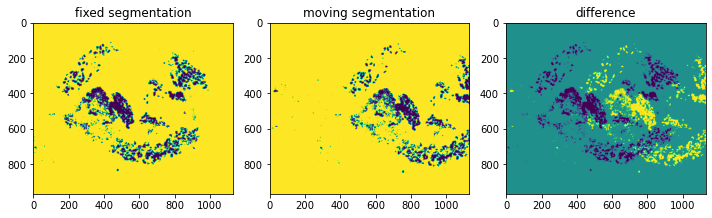

##################################################
registered_core=70_round=R2_color=c1.tif
##################################################
jacaard: 0.2497803608839629
dice: 0.3997188125236576
volume similarity: 0.028010598604877517
FPR: 0.60580204778157
FNR: 0.5946034879894703
hausdorff dist: 0.02632285510070737


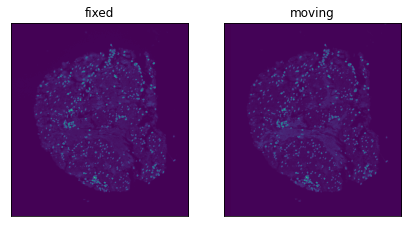

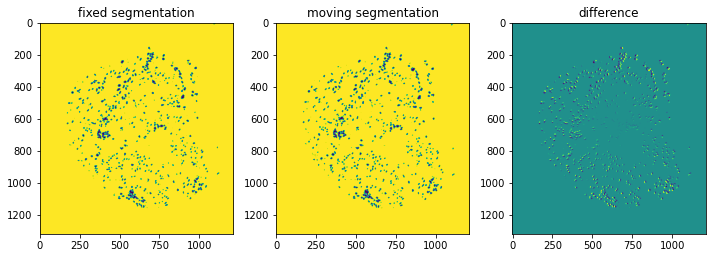

##################################################
registered_core=63_round=R2_color=c1.tif
##################################################
jacaard: 0.5242124699365507
dice: 0.6878469770797406
volume similarity: 0.04528496969556679
FPR: 0.3273827488380516
FNR: 0.2962176415325223
hausdorff dist: 0.3107500325345943


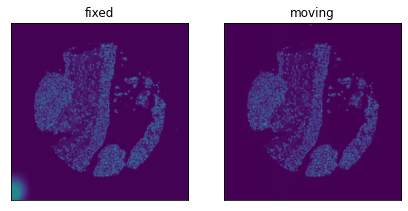

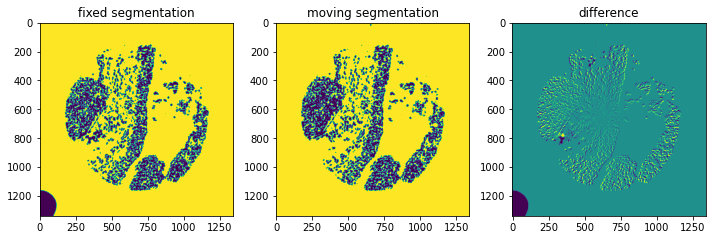

##################################################
registered_core=63_round=R1_color=c1.tif
##################################################
jacaard: 0.6817097433678739
dice: 0.8107341306147738
volume similarity: -0.07904572622241869
FPR: 0.155904810768395
FNR: 0.2200901400202868
hausdorff dist: 0.3112832178681603


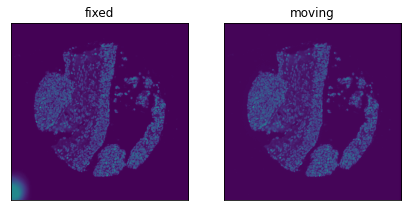

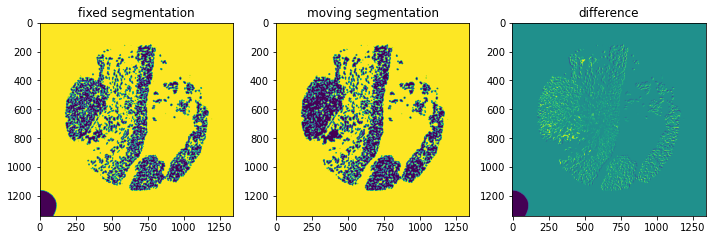

##################################################
registered_core=54_round=R1_color=c1.tif
##################################################
jacaard: 0.7356008202323991
dice: 0.8476612959123876
volume similarity: 0.03703867069105665
FPR: 0.1677513950927381
FNR: 0.13634437596302004
hausdorff dist: 0.2650687313206587


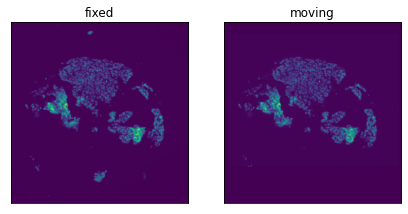

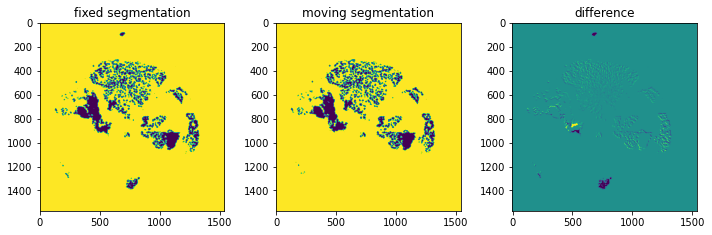

##################################################
registered_core=71_round=R2_color=c1.tif
##################################################
jacaard: 0.3069242069321476
dice: 0.4696893749525329
volume similarity: 1.0388361476080774
FPR: 0.6908754851279272
FNR: 0.022665336854526045
hausdorff dist: 0.13939206509401006


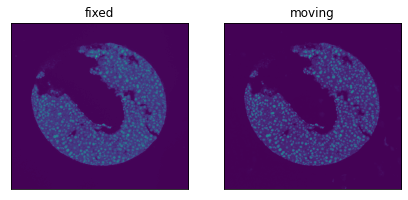

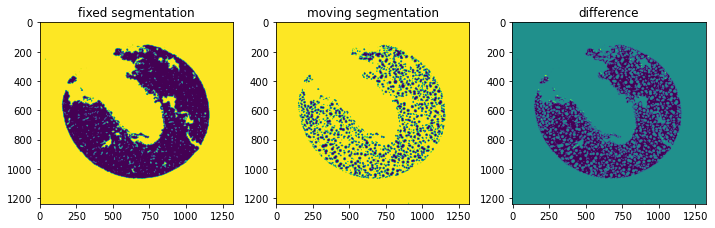

##################################################
registered_core=43_round=R2_color=c1.tif
##################################################
jacaard: 0.29562093037440096
dice: 0.4563386148585514
volume similarity: 0.9607772929128084
FPR: 0.6917440457606279
FNR: 0.1217693536785579
hausdorff dist: 0.10846376614739577


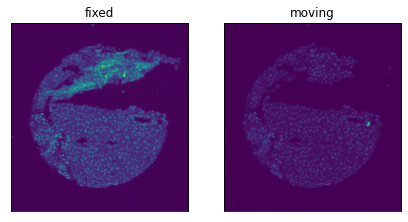

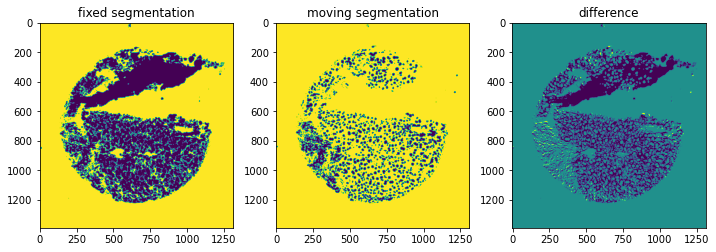

In [33]:
# for each core 
for i, row in outRes.iterrows(): 
    print('#'*50)
    print(row['name'])
    print('#'*50)
    print('jacaard:', row.jacaard_coef)
    print('dice:', row.dice_coef)
    print('volume similarity:', row.volume_similarity)
    print('FPR:', row.false_pos_err)
    print('FNR:', row.false_neg_err)
    print('hausdorff dist:', row.hausdorff_dist)
    img = sitk.ReadImage(row.registered_path)
    #utils.myshow(img)
    
    R0_dapi_path = f'{"/".join(row.registered_path.split("/")[:-1])}/unregistered_core={int(row.cluster)}_round=R0_color=c1.tif'
    
    R0_img = sitk.ReadImage(R0_dapi_path)
    #utils.myshow(img)
    
    f, axes = plt.subplots(1,2, figsize=(7,14))
    utils.myshow(R0_img, title='fixed', ax=axes[0])
    utils.myshow(img, title='moving', ax=axes[1])
    
    evaluate.plot_registration(R0_img, img)


# Registration Visualization

Build in some interactive widgets to visualize mapping. eg scroll select for which core(1) and round(R0 + 2) to include. 

Just a convenient way to pan through and visualize images. 

In [4]:
core_dir = '/home/exacloud/lustre1/NGSdev/evansna/cyclicIF/output/S3/Scene-1/core-001'
os.listdir(core_dir)

['unregistered_core=1_round=R2_color=c1.tif',
 'unregistered_core=1_round=R2_color=c2.tif',
 'unregistered_core=1_round=R0_color=c3.tif',
 'registered_core=1_round=R2_color=c3.tif',
 'registered_core=1_round=R1_color=c1.tif',
 'unregistered_core=1_round=R2_color=c3.tif',
 'unregistered_core=1_round=R2_color=c4.tif',
 'unregistered_core=1_round=R0_color=c5.tif',
 'registered_core=1_round=R2_color=c4.tif',
 'registered_core=1_round=R1_color=c3.tif',
 'unregistered_core=1_round=R2_color=c5.tif',
 'registered_core=1_round=R2_color=c2.tif',
 'registered_core=1_round=R1_color=c2.tif',
 'registered_core=1_round=R2_color=c5.tif',
 'unregistered_core=1_round=R0_color=c2.tif',
 'unregistered_core=1_round=R1_color=c5.tif',
 'unregistered_core=1_round=R1_color=c3.tif',
 'unregistered_core=1_round=R1_color=c4.tif',
 'unregistered_core=1_round=R1_color=c1.tif',
 'registered_core=1_round=R1_color=c5.tif',
 'registered_core=1_round=R1_color=c4.tif',
 'registered_core=1_round=R2_color=c1.tif',
 'unregi

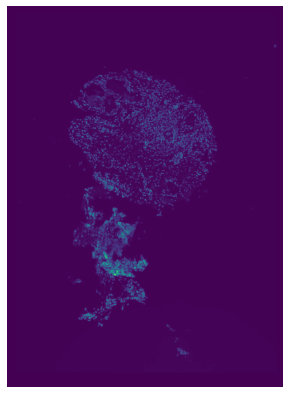

In [14]:
core0 = sitk.ReadImage(core_dir + '/unregistered_core=1_round=R0_color=c1.tif')
utils.myshow(core)

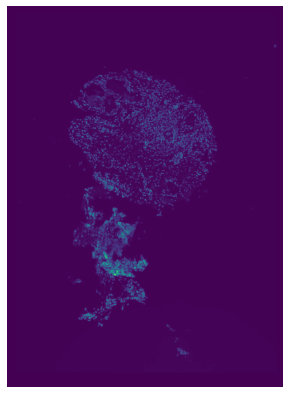

In [15]:
core1 = sitk.ReadImage(core_dir + '/registered_core=1_round=R1_color=c1.tif')
utils.myshow(core)

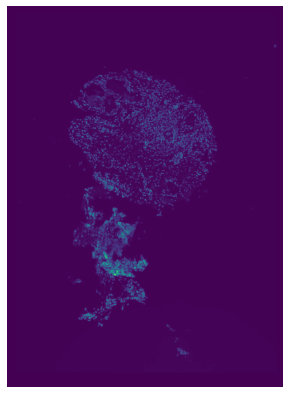

In [16]:
core2 = sitk.ReadImage(core_dir + '/registered_core=1_round=R2_color=c1.tif')
utils.myshow(core)

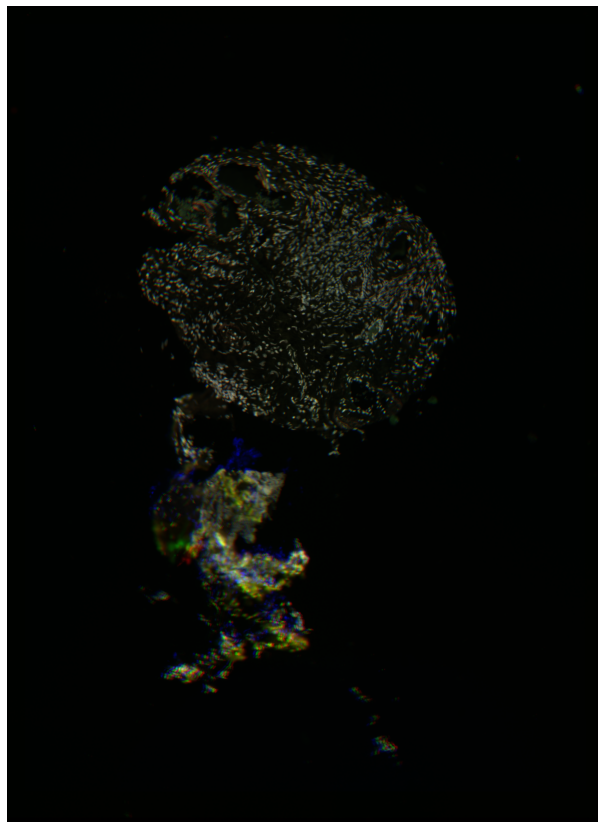

In [19]:
sigm1 = sitk.Cast(sitk.RescaleIntensity(core0), sitk.sitkUInt8)
sigm2 = sitk.Cast(sitk.RescaleIntensity(core1), sitk.sitkUInt8)
sigm3 = sitk.Cast(sitk.RescaleIntensity(core2), sitk.sitkUInt8)

cimg = sitk.Compose(sigm1, sigm2, sigm3)

utils.myshow(cimg, figsize=(15,15))

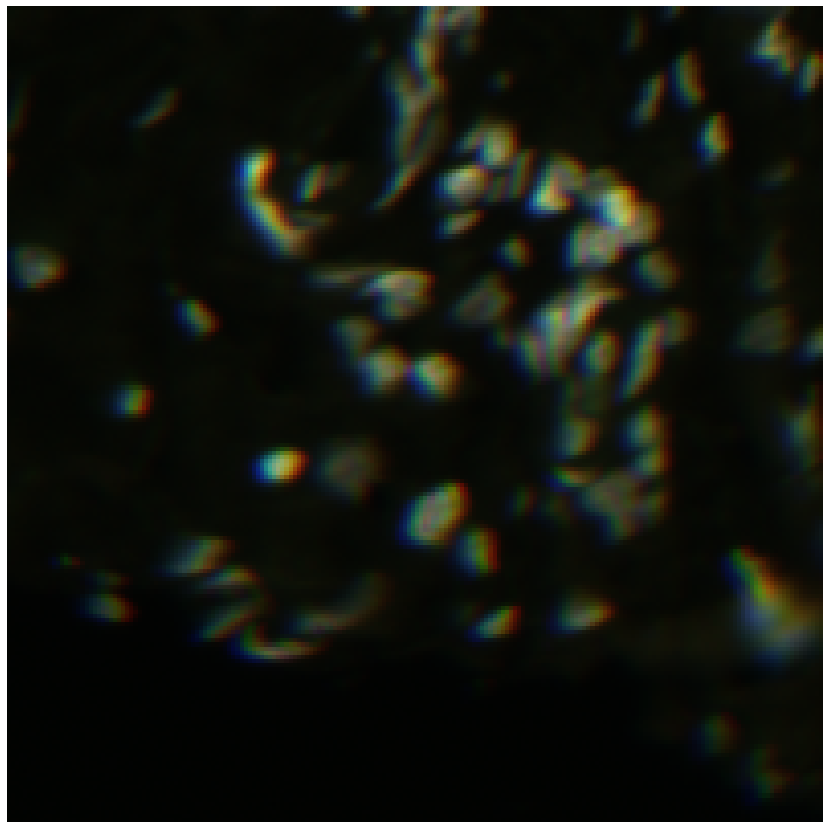

In [22]:
wsize = 100
x,y = cimg.GetSize()
utils.myshow(cimg[int(x/2-wsize):int(x/2+wsize), int(y/2-wsize):int(y/2+wsize)], figsize=(15,15))